# Analiza sentimenta

Ovaj se projekt analizira skup podataka "hotel review" dobivenog iz Kaggle.com. Započinje uvozom i ispitivanjem strukture i vrijednosti skupa podataka, nakon čega slijede vizualizacije koje prikazuju detalje poput preglednika i uređaja koji se koriste prilikom davanja recenzije.
Zatim slijedi predobrada/čišćenje podataka kako bi se osigurala kvaliteta istih. Izgradit će se vlastiti model strojnog učenja, a trenirat će ga se pomoću datoteke "train.csv". Evaluacijom performansi pomoću matrice konfuzije procijenit će se točnost modela, a ista će se testirati i na datoteci "test.csv" i na ručnom unosu kraće recenzije korisnika ili duže recenzije putem datoteke "recenzija.txt".



In [ ]:
import sys
print(f'Verzija koju koristi ovaj Google Colab je: {sys.version}')

Verzija koju koristi ovaj Google Colab je: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]


## Učitavanje podataka

In [ ]:
from google.colab import files

# Ucitavanje 'train.csv' file
uploaded = files.upload()

# Ispis naziva svih ucitanih datoteka

for filename in uploaded.keys():
    print(f'Datoteka "{filename}" je uspješno učitana na okruženje Google Colab-a!')


Saving test.csv to test.csv
Saving train.csv to train.csv
Datoteka "test.csv" je uspješno učitana na okruženje Google Colab-a!
Datoteka "train.csv" je uspješno učitana na okruženje Google Colab-a!


In [1]:
import pandas as pd

# Spremanje train.csv u varijablu train_data

train_data = pd.read_csv("/content/train.csv")

In [ ]:
# Pregled oblika podataka

train_data.shape

(38932, 5)

Ovo znači da skup podataka "train_data" ima oblik (broj redaka, broj stupaca) jednak (38932, 5).

In [ ]:
# Svaki novi redak u skupu podataka je jedna nova recenzija

print("Ukupan broj recenzija u skupu za treniranje: {} ".format(len(train_data)))

Ukupan broj recenzija u skupu za treniranje: 38932 


In [ ]:
# Provjera ako ima nedostajućih vrijednosti u skupu podataka

train_data.isnull().sum()

User_ID         0
Description     0
Browser_Used    0
Device_Used     0
Is_Response     0
dtype: int64

In [ ]:
# Prikaz prvih 5 redaka u train.csv skupu podataka

train_data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


## Vizualizacija podataka

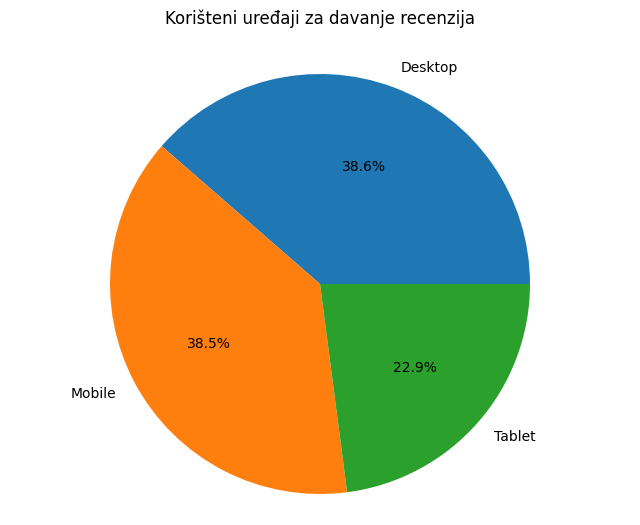

In [ ]:
import matplotlib.pyplot as plt

device_counts = train_data['Device_Used'].value_counts()

plt.figure(figsize=(8, 6))
plt.pie(device_counts, labels=device_counts.index, autopct='%1.1f%%')
plt.title('Korišteni uređaji za davanje recenzija\n')
plt.axis('equal')  # Jednaki omjer sirine i visine osigurava da se iscrta krug.
plt.show()

In [ ]:
# Prikaz koristenih browsera prilikom davanja recenzije

print(train_data['Browser_Used'].value_counts())

Firefox              7367
Edge                 7134
Google Chrome        4659
InternetExplorer     4588
Mozilla Firefox      4328
Mozilla              3092
Chrome               2470
IE                   2439
Internet Explorer    2103
Safari                390
Opera                 362
Name: Browser_Used, dtype: int64


Možemo primjetiti da se jednake vrijednosti pojavljuju više puta, ali pod različitim imenom kao što su na primjer "InternetExplorer", "Internet Explorer", "IE" i "Edge". Kada bi to grafički prikazali svaka vrijednost bi se zasebno prikazala iako se radi o istom pregledniku. Ovaj dio možemo lako popraviti tako da mapiramo iste preglednike u jedan naziv i zatim prikazati histogram stvarnih vrijednosti.

In [ ]:
# Mapiranje za popravljanje i preimenovanje preglednika
browser_mapping = {
    "Google Chrome": "Chrome",
    "InternetExplorer": "Internet Explorer",
    "IE": "Internet Explorer",
    "Edge": "Internet Explorer",
    "Mozilla": "Firefox",
    "Mozilla Firefox": "Firefox"
}


train_data['Browser_Used'] = train_data['Browser_Used'].replace(browser_mapping)

In [ ]:
print(train_data['Browser_Used'].value_counts())

Internet Explorer    16264
Firefox              14787
Chrome                7129
Safari                 390
Opera                  362
Name: Browser_Used, dtype: int64


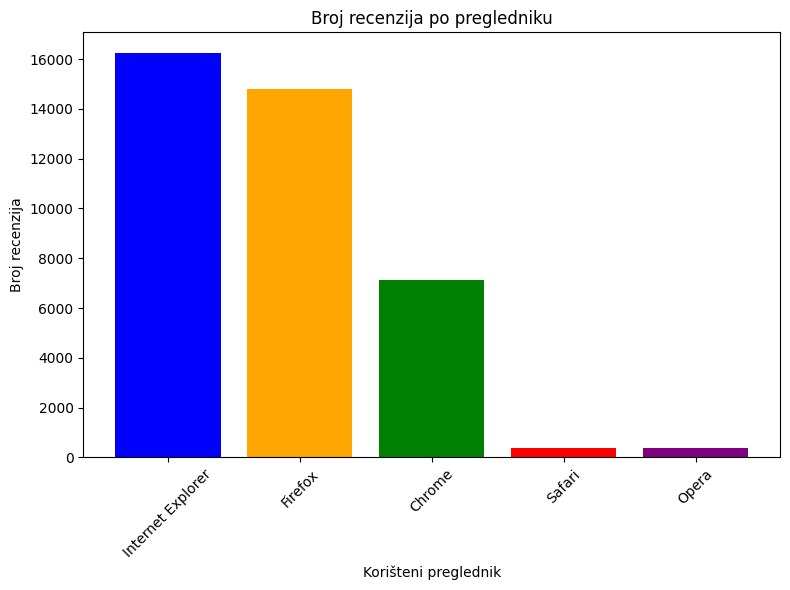

In [ ]:
# Broj pojavljivanja svakog preglednika
browser_counts = train_data['Browser_Used'].value_counts()

# Definiranje boja za bolju i ljepsu vizualizaciju kategorija preglednika
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Kreiranje histograma
plt.figure(figsize=(8, 6))
plt.bar(browser_counts.index, browser_counts, color=colors)
plt.xlabel('Korišteni preglednik')
plt.ylabel('Broj recenzija')
plt.title('Broj recenzija po pregledniku')
plt.xticks(rotation=45)  # Rotiranje oznaka x-osi za bolju citljivost
plt.tight_layout()
plt.show()

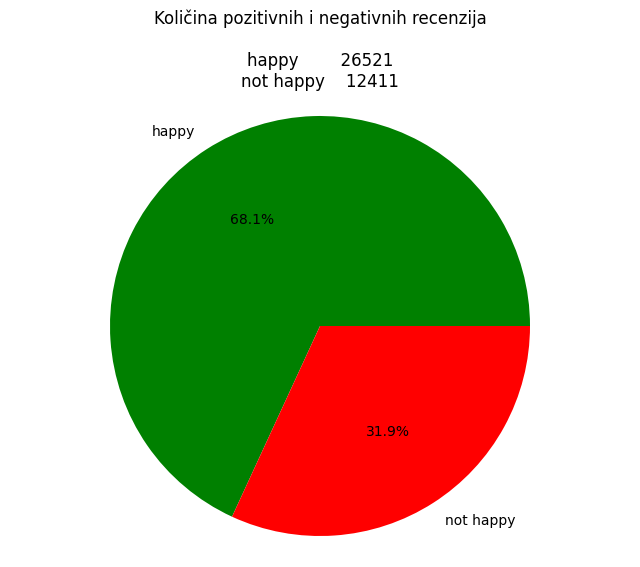

In [ ]:
# Prebrojavajne odgovora
response_counts = train_data['Is_Response'].value_counts()

colors = ['green', 'red']

plt.figure(figsize=(8, 6))
plt.pie(response_counts, labels=response_counts.index, autopct='%1.1f%%', colors=colors)
plt.title(f'Količina pozitivnih i negativnih recenzija\n\n{response_counts.to_string()}')
plt.axis('equal')  # Jednaki omjer sirine i visine osigurava da se iscrta krug.
plt.show()


## Čišćenje podataka

In [2]:
# Pikaz kako izgleda nas dataset

train_data.head()

,User_ID,Description,Browser_Used,Device_Used,Is_Response
0,id10326,The room was kind of clean but had a VERY stro...,Edge,Mobile,not happy
1,id10327,I stayed at the Crown Plaza April -- - April -...,Internet Explorer,Mobile,not happy
2,id10328,I booked this hotel through Hotwire at the low...,Mozilla,Tablet,not happy
3,id10329,Stayed here with husband and sons on the way t...,InternetExplorer,Desktop,happy
4,id10330,My girlfriends and I stayed here to celebrate ...,Edge,Tablet,not happy


In [3]:
# Micanje nepotrebnih stupaca za analizu sentimenta

clean_data = train_data[['Description', 'Is_Response']].copy()
clean_data.head()

,Description,Is_Response
0,The room was kind of clean but had a VERY stro...,not happy
1,I stayed at the Crown Plaza April -- - April -...,not happy
2,I booked this hotel through Hotwire at the low...,not happy
3,Stayed here with husband and sons on the way t...,happy
4,My girlfriends and I stayed here to celebrate ...,not happy


In [4]:
#import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Prikaz jednog od nacina kako raditi predobradu/ciscenje teksta (ovaj ocisceni dataset cemo koristit za word cloud),
# kasnije cemo napraviti funkcije koje cemo pozivat za ciscenje i vektorizaciju primjenjive i na novim recenzijama

# Koraci predobrade direktno primijenjeni na stupac 'Description'
clean_data['Description'] = clean_data['Description'].str.lower()  # Pretvara tekst u mala slova
clean_data['Description'] = clean_data['Description'].str.replace('[,\.!?:()"]', '')  # Uklanja interpunkcijske znakove
clean_data['Description'] = clean_data['Description'].str.replace('[^a-zA-Z"]', ' ')  # Uklanja sve sto nije slovo ili navodnik
clean_data['Description'] = clean_data['Description'].str.replace('[^\w\s]|(\W*\d\w*)', '', regex=True)  # Uklanja znakove koji nisu alfanumerički, osim razmaka, te odredjene sekvence s brojevima
clean_data['Description'] = clean_data['Description'].str.strip()  # Uklanja nepotrebne praznine na pocetku i kraju teksta
sw = set(stopwords.words("english"))
clean_data['Description'] = clean_data['Description'].apply(lambda x: ' '.join(word for word in x.split() if word not in sw and word != 'th'))  # Uklanja stopwords iz teksta

# Prikaz modificiranog DataFrame-a
print(clean_data)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
<ipython-input-4-89c3253b5539>:12: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_data['Description'] = clean_data['Description'].str.replace('[,\.!?:()"]', '')  # Uklanja interpunkcijske znakove
<ipython-input-4-89c3253b5539>:13: FutureWarning: The default value of regex will change from True to False in a future version.
  clean_data['Description'] = clean_data['Description'].str.replace('[^a-zA-Z"]', ' ')  # Uklanja sve sto nije slovo ili navodnik


                                             Description Is_Response
0      room kind clean strong smell dogs generally av...   not happy
1      stayed crown plaza april april staff friendly ...   not happy
2      booked hotel hotwire lowest price could find g...   not happy
3      stayed husband sons way alaska cruise loved ho...       happy
4      girlfriends stayed celebrate birthdays planned...   not happy
...                                                  ...         ...
38927  arrived late night walked check area completel...       happy
38928  positive impression location public parking op...   not happy
38929  traveling friends shopping show location great...   not happy
38930  experience ok paid extra view pool got view pa...   not happy
38931  westin wonderfully restored grande dame hotel ...       happy

[38932 rows x 2 columns]


Prikaz kako je tekst izgledao prije čišćenja:

In [5]:
train_data["Description"].head(5).tolist()

["The room was kind of clean but had a VERY strong smell of dogs. Generally below average but ok for a overnight stay if you're not too fussy. Would consider staying again if the price was right. Breakfast was free and just about better than nothing.",
 "I stayed at the Crown Plaza April -- - April --, ----. The staff was friendly and attentive. The elevators are tiny (about -' by -'). The food in the restaurant was delicious but priced a little on the high side. Of course this is Washington DC. There is no pool and little for children to do. My room on the fifth floor had two comfortable beds and plenty of space for one person. The TV is a little small by todays standards with a limited number of channels. There was a small bit of mold in the bathtub area that could have been removed with a little bleach. It appeared the carpets were not vacummed every day. I reported a light bulb was burned out. It was never replaced. Ice machines are on the odd numbered floors, but the one on my flo

Prikaz kako tekst izgleda nakon čišćenja:

In [6]:
clean_data['Description'].head(5).tolist()

['room kind clean strong smell dogs generally average ok overnight stay fussy would consider staying price right breakfast free better nothing',
 'stayed crown plaza april april staff friendly attentive elevators tiny food restaurant delicious priced little high side course washington dc pool little children room fifth floor two comfortable beds plenty space one person tv little small todays standards limited number channels small bit mold bathtub area could removed little bleach appeared carpets vacummed every day reported light bulb burned never replaced ice machines odd numbered floors one floor work encountered staff elevator one evening mentioned ice machine severel hours later maid appeared door ice two mints sure knew room little unnerving would stay business would come vacation',
 'booked hotel hotwire lowest price could find got front desk manager gave us smoking room argued little baby would booked room known smoking manager would hear anything told hotwire books cheapest roo

Sada kada smo vidjeli kako izgleda očišćeni tekst (kojeg ćemo kasnije koristiti za word cloud) napraviti ćemo funkcije koje ćemo moći pozvat na bilo kojoj recenziji da očiste tekst i vektoriziraju ga.

**Koristimo SpaCy biblioteku koja upravlja i tokenizacijom i vektorizacijom u svom internom pipeline-u.** Omogućuje da se dobiju vektori riječi za svaki token u tekstu bez eksplicitnog pozivanja zasebnih funkcija tokenizacije ili vektorizacije.

In [7]:
!python -m spacy download en_core_web_md

2024-01-19 01:01:13.388851: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-19 01:01:13.388930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-19 01:01:13.391117: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-19 01:01:13.403446: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-01-19 01:01:15.323097: W tensorflow/comp

In [8]:
import spacy

# Ucitavanje spaCy modela s GloVe ugradjenim elementima
nlp = spacy.load('en_core_web_md')

# Funkcija za predobradu teksta: pretvaranje u mala slova, uklanjanje interpunkcija, brojeva i stop rijeci
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[,\.!?:()"]', '', text) # Uklanjanje interpunkcijskih znakova
    text = re.sub('[^a-zA-Z"]', ' ', text) # Zadrzavanje samo slova i navodnika
    text = re.sub('[^\w\s]|(\W*\d\w*)', '', text) # Uklanjanje svega osim rijeci i razmaka
    text = text.strip()
    sw = set(stopwords.words("english")) # Postavljanje engleskih stop rijeci
    text = ' '.join(word for word in text.split() if word not in sw and word != 'th')  # Uklanjanje stop riječi i rijeci "th"
    return text
    return text

# Funkcija za obradu recenzije: predobrada teksta, tokenizacija i dobivanje vektora za svaki token
def process_review(review):
    cleaned_review = preprocess_text(review)
    doc = nlp(cleaned_review)
    review_vectors = [token.vector for token in doc] # Dobivanje vektora za svaki token u recenziji
    return review_vectors

## Word Clouds & ngram


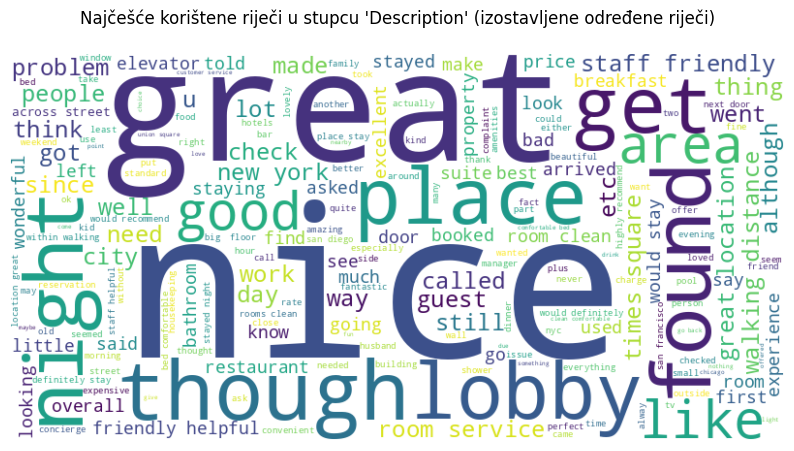

In [ ]:
from wordcloud import WordCloud
#import matplotlib.pyplot as plt

# Spajanje tekstualnih podataka u jedan niz
text_combined = ' '.join(clean_data['Description'])

# Definiranje riječi koje želimo izuzeti
custom_stopwords = ["front", "desk", "however", "also", "really", "one", "hotel", "even"]

# Stvaranje Word Cloud uz izostavljanje određenih riječi
wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=custom_stopwords).generate(text_combined)

# Prikaz Word Cloud pomocu matplotlib
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Najčešće korištene riječi u stupcu 'Description' (izostavljene određene riječi)\n")
plt.show()


within walking distance : 1499
front desk staff : 1345
staff friendly helpful : 1106
would definitely stay : 991
hotel great location : 703
flat screen tv : 679
would recommend hotel : 674
stayed one night : 568
empire state building : 539
called front desk : 488


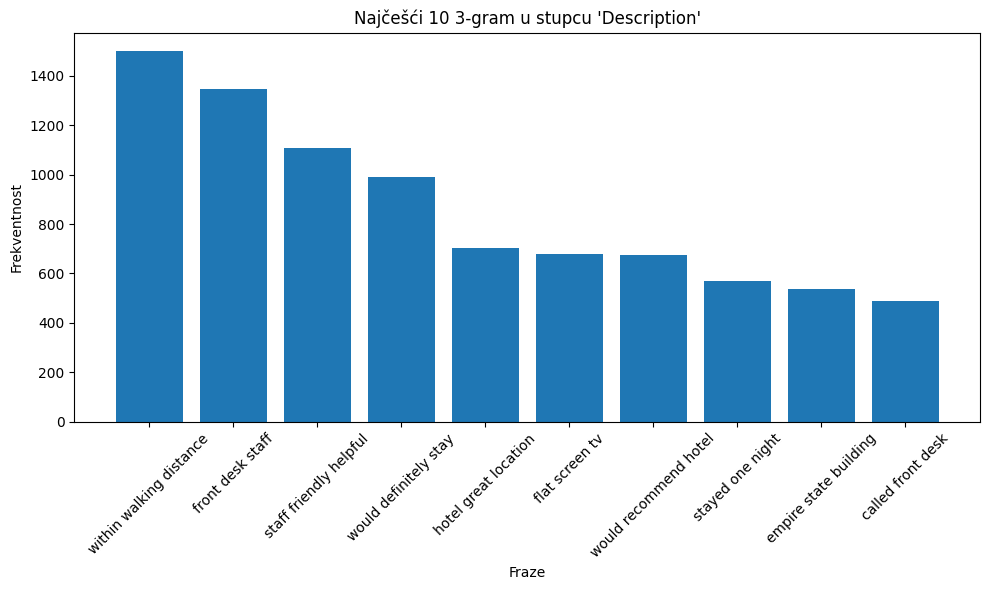

In [ ]:
from nltk import ngrams
from collections import Counter
#import matplotlib.pyplot as plt

text_combined = ' '.join(clean_data['Description'])


# # Tokenizacija teksta na rijeci
words = text_combined.split()

# Broj n-grama, u nasem slucaju zelimo vidjeti trigram
n = 3

# Generiranje ngrama
n_grams = ngrams(words, n)

# Brojanje pojavljivanja svakog n-grama
ngram_freq = Counter(n_grams)

# Odabir koliko ngrama zelimo prikazati
top_n = 10

# Najcesci ngrami
top_ngrams = ngram_freq.most_common(top_n)

# Prikaz najcescih ngrama
for ngram, frequency in top_ngrams:
    print(' '.join(ngram), ':', frequency)

# Vizualizacija
labels, values = zip(*[(f"{' '.join(ngram)}", frequency) for ngram, frequency in top_ngrams])

plt.figure(figsize=(10, 6))
plt.bar(labels, values)
plt.title(f"Najčešći {top_n} {n}-gram u stupcu 'Description'")
plt.xlabel("Fraze")
plt.ylabel("Frekventnost")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


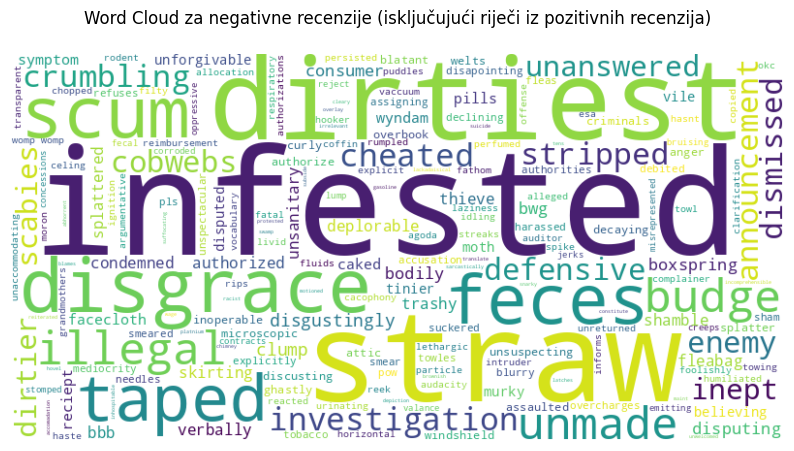

In [ ]:
# Filtriranje pozitivnih recenzija
positive_reviews = clean_data[clean_data['Is_Response'] == 'happy']

# Filtriranje negativnih recenzija
negative_reviews = clean_data[clean_data['Is_Response'] == 'not happy']

# Dobivanje tekstualnih podataka iz negativnih recenzija
text_data_negative = ' '.join(negative_reviews['Description'].astype(str))

# Dobivanje tekstualnih podataka iz pozitivnih recenzija
text_data_positive = ' '.join(positive_reviews['Description'].astype(str))

# Stvaranje word cloud-a za negativne recenzije isključujući riječi iz pozitivnih recenzija
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=set(text_data_positive.split())).generate(text_data_negative)

# Prikazivanje word cloud-a
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud za negativne recenzije (isključujući riječi iz pozitivnih recenzija)\n')
plt.show()


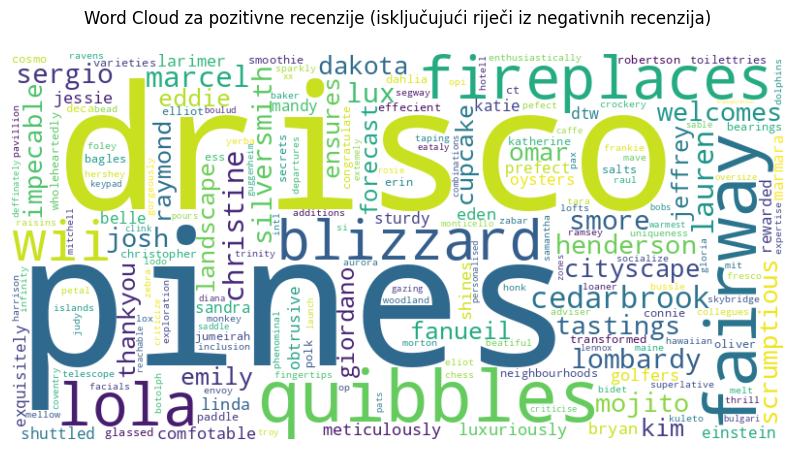

In [ ]:
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=set(text_data_negative.split())).generate(text_data_positive)

# Prikazivanje word cloud-a
plt.figure(figsize=(10, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud za pozitivne recenzije (isključujući riječi iz negativnih recenzija)\n')
plt.show()

## Treniranje modela

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Učitaj spaCy model s ugradjenim GloVe elementima
nlp = spacy.load('en_core_web_md')

# Priprema podataka
X = clean_data['Description'].astype(str)
X = X.apply(preprocess_text)  # Primijena funkcije preprocess_text za ciscenje teksta

y = clean_data['Is_Response']
label_mapping = {'happy': 1, 'not happy': 0}
y = y.map(label_mapping).astype(float)

# Podjela podataka
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)

# Obrada tokeniziranog teksta pomocu SpaCyja za izdvajanje vektora rijeci
X_train_vectors = np.array([nlp(text).vector for text in X_train])
X_val_vectors = np.array([nlp(text).vector for text in X_val])
X_test_vectors = np.array([nlp(text).vector for text in X_test])

# Prilagodba oblika unosa kako bi model prihvatio vektore
input_shape = X_train_vectors.shape[1]

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(input_shape,)),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Kompajliranje i treniranje modela koristenjem word vectora
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Treniranje modela koristeći vektore riječi kao ulazne podatke
history = model.fit(X_train_vectors, y_train, epochs=500, batch_size=32,
                    validation_data=(X_val_vectors, y_val), verbose=2)

# Evaluacija modela na test dijelu podataka
test_loss, test_accuracy = model.evaluate(X_test_vectors, y_test)
train_loss, train_accuracy = model.evaluate(X_train_vectors, y_train)

print(f'Test accuracy: {test_accuracy * 100:.2f}%')
print(f'Training accuracy: {train_accuracy * 100:.2f}%')

Epoch 1/500
876/876 - 9s - loss: 0.5916 - accuracy: 0.6715 - val_loss: 0.5097 - val_accuracy: 0.6873 - 9s/epoch - 10ms/step
Epoch 2/500
876/876 - 4s - loss: 0.5002 - accuracy: 0.7869 - val_loss: 0.4582 - val_accuracy: 0.8138 - 4s/epoch - 4ms/step
Epoch 3/500
876/876 - 4s - loss: 0.4766 - accuracy: 0.8005 - val_loss: 0.4658 - val_accuracy: 0.8100 - 4s/epoch - 5ms/step
Epoch 4/500
876/876 - 3s - loss: 0.4653 - accuracy: 0.8064 - val_loss: 0.4974 - val_accuracy: 0.7926 - 3s/epoch - 4ms/step
Epoch 5/500
876/876 - 3s - loss: 0.4514 - accuracy: 0.8120 - val_loss: 0.4805 - val_accuracy: 0.8103 - 3s/epoch - 4ms/step
Epoch 6/500
876/876 - 4s - loss: 0.4469 - accuracy: 0.8172 - val_loss: 0.4992 - val_accuracy: 0.8055 - 4s/epoch - 5ms/step
Epoch 7/500
876/876 - 3s - loss: 0.4407 - accuracy: 0.8198 - val_loss: 0.4879 - val_accuracy: 0.8177 - 3s/epoch - 4ms/step
Epoch 8/500
876/876 - 3s - loss: 0.4339 - accuracy: 0.8191 - val_loss: 0.4443 - val_accuracy: 0.8215 - 3s/epoch - 4ms/step
Epoch 9/500
876

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               77056     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 32)                2

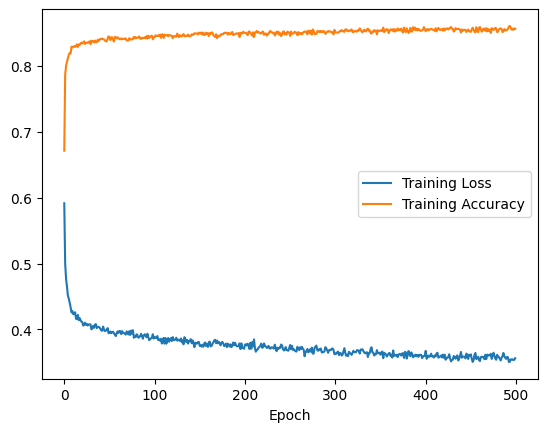

In [13]:
# Vizualizacija promjena gubitka (loss) i točnosti (accuracy) tijekom treniranja modela
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

244/244 [==============================] - 1s 3ms/step


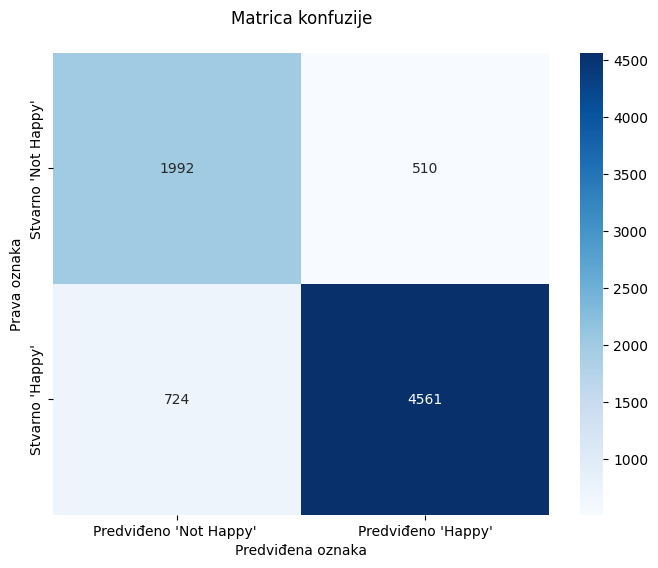

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Predvidjanje vjerojatnosti na temelju testnih podataka
y_pred_prob = model.predict(X_test_vectors)

# Pretvorba vjerojatnosti u klase (0 ili 1)
y_pred = (y_pred_prob > 0.5).astype(int)

# Generiranje matrice konfuzije
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Blues', fmt='d',
            xticklabels=["Predviđeno 'Not Happy' ", "Predviđeno 'Happy'"],
            yticklabels=["Stvarno 'Not Happy'", "Stvarno 'Happy'"])

plt.xlabel('Predviđena oznaka')
plt.ylabel('Prava oznaka')
plt.title('Matrica konfuzije\n')
plt.show()



In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score

# Izracun tocnosti
accuracy = accuracy_score(y_test, y_pred)
print(f'Točnost: {accuracy * 100:.2f}%')

# Izracun preciznosti
precision = precision_score(y_test, y_pred)
print(f'Preciznost: {precision * 100:.2f}%')

# Izracun opoziva
recall = recall_score(y_test, y_pred)
print(f'Odziv: {recall * 100:.2f}%')

Točnost: 84.15%
Preciznost: 89.94%
Odziv: 86.30%


## Testiranje modela

In [61]:
# Spremanje test.csv u varijablu test_data

test_data = pd.read_csv("/content/test.csv")

In [62]:
test_data.head()

,User_ID,Description,Browser_Used,Device_Used
0,id80132,Looking for a motel in close proximity to TV t...,Firefox,Mobile
1,id80133,Walking distance to Madison Square Garden and ...,InternetExplorer,Desktop
2,id80134,Visited Seattle on business. Spent - nights in...,IE,Tablet
3,id80135,This hotel location is excellent and the rooms...,Edge,Mobile
4,id80136,This hotel is awesome I love the service Antho...,Mozilla,Mobile


In [63]:
test_data.shape

(29404, 4)

In [64]:
test_data['Description'][0]

"Looking for a motel in close proximity to TV taping of a Dr. Phil show, we chose the Dunes on Sunset Blvd in West Hollywood. Although the property displayed the AAA emblem, it certainly left a lot to be desired. There were chips & scrapes on the bottom of the door frame in the bathroom and the lotion containers were half full--apparently not replaced by housekeeping. We needed an early wakeup call, but couldn't use the clock radio alarm as there wasn't a radio in the room. There was no TV channel listing on the remote, or on the TV menu making viewing a chore.The TV remote had to be returned when checking-out. This place served its purpose, but not a place to revisit."

In [65]:
test_data['Description'][29403]

'The Blakely is is comfortable is every way: the rooms are nicely furnished, the lnens are good quality, closets are roomy, the bathrooms are well-equipped, the tea-coffee self-service is convenient-- and it is nice having book shelves in the room, with hard-bound books !\nThe Blakely really distinguishes itself in *service* ! I requested a room with a quiet location, and the request was honored with courtesy. When I arrived, the front desk, serviced by Marleni, confirmed a dinner reservation, and Marleni also took care of requests for small problems with the bathroom tub-drain, quickly, efficiently, and courteously.\nThe hotel is located on a quiet (for NYC) side street, West --th, about a block from Sixth Avenue, and near Seventh Avenue-Broadway--Times Square -- but the feeling is """"""""""""""""""""""""""""""""miles away"""""""""""""""""""""""""""""""" from the density of those areas.\nThe Blakely is great !'

In [66]:
clean_test_data = test_data[['Description']].copy()
clean_test_data.head()

,Description
0,Looking for a motel in close proximity to TV t...
1,Walking distance to Madison Square Garden and ...
2,Visited Seattle on business. Spent - nights in...
3,This hotel location is excellent and the rooms...
4,This hotel is awesome I love the service Antho...


In [67]:
clean_test_data['Cleaned_Description'] = clean_test_data['Description'].apply(preprocess_text)

In [68]:
clean_test_data.head()

,Description,Cleaned_Description
0,Looking for a motel in close proximity to TV t...,looking motel close proximity tv taping dr phi...
1,Walking distance to Madison Square Garden and ...,walking distance madison square garden penn su...
2,Visited Seattle on business. Spent - nights in...,visited seattle business spent nights vintage ...
3,This hotel location is excellent and the rooms...,hotel location excellent rooms clean suite one...
4,This hotel is awesome I love the service Antho...,hotel awesome love service anthony really grea...


In [52]:
import random # Za dobivanje random recenzije iz testnih (ne vidjenih podataka) - opcija 3
from google.colab import files

def prepare_input(review):
    cleaned_review = preprocess_text(review)
    review_vector = np.array([nlp(cleaned_review).vector])  # Pretvorba u numpy array
    return review_vector

def check_repeat_input():
    while True:
        repeat = input("Želite li analizirati još jednu recenziju? (da/ne): ").lower()
        if repeat == 'ne':
            return False  # Vrati False ako je unos 'ne', što će prekinuti petlju u pozivajućem kodu
        elif repeat == 'da':
            return True  # Vrati True ako je unos 'da', što će omogućiti nastavak petlje u pozivajućem kodu
        else:
            print("Nevažeći unos. Molimo unesite 'da' ili 'ne'.")

def get_review(option):
    while True:
        try:
            if option == 1:
                uploaded = files.upload()  # Upload .txt datoteke s dugom recenzijom (ona koju ne mozemo sami napisati u google colab)
                file_path = list(uploaded.keys())[0]
                try:
                    with open(file_path, 'r') as file:
                        review = file.read()
                    print(f"\nSadržaj .txt datoteke:\n{review}")  # Ispis sadrzaja upload-ane .txt datoteke
                    return review  # Vrati sadrzaj prenesene .txt datoteke
                except FileNotFoundError:
                    print("Datoteka nije pronađena.")

            elif option == 2:
                review = input("Unesite kratku recenziju: ")  # Unos kratke recenzije
                return review

            elif option == 3:
                random_index = random.randint(0, len(clean_test_data) - 1)  # Generiranje random recenzije iz clean_test_data
                review = clean_test_data['Cleaned_Description'][random_index]
                return random_index, review

            else:
                print("Nevažeća opcija.")
                return None  # Vrati None za nevažeću opciju.

        except ValueError:
            print("Nevažeći unos. Molimo unesite broj (1, 2 ili 3).")

        if not check_repeat_input():
            break  # Ako funkcija vrati False, prekini petlju

# Glavni dio programa
while True:
    try:
        print("\n1 - Uploadajte .txt datoteku s dugom recenzijom")
        print("2 - Unesite kratku recenziju")
        print("3 - Izvršite analizu sentimenta na nasumičnoj recenziji iz clean_test_data\n")
        chosen_option = int(input("Odaberite opciju (1, 2 ili 3): "))

        user_review = get_review(chosen_option)
        if user_review:
            if isinstance(user_review, tuple):
                random_index, user_review = user_review
                print(f"\nBroj recenzije: {random_index}. \nRecenzija:\n{clean_test_data['Description'][random_index]}")

            # Pripremanje ulaznih podataka za predviđanje
            review_vectors = prepare_input(user_review)

            cleaned_review = preprocess_text(user_review)
            print(f"\nOčišćena recenzija:\n{cleaned_review}")

            # Predviđanje sentimenta na temelju vektora recenzije
            prediction = model.predict(review_vectors)
            if prediction > 0.5:
                print("\nAnaliza sentimenta: 'Pozitivna recenzija! 😊'.\n ")
                print("---------------------------------------------------\n")
            else:
                print("\nAnaliza sentimenta: 'Negativna recenzija... 😞'.\n")
                print("---------------------------------------------------\n")

        if not check_repeat_input():
            break  # Ako funkcija vrati False, prekini glavnu petlju

    except ValueError:
        print("\nNevažeći unos. Molimo unesite broj (1, 2 ili 3).")

print("\nKraj programa.")



1 - Uploadajte .txt datoteku s dugom recenzijom
2 - Unesite kratku recenziju
3 - Izvršite analizu sentimenta na nasumičnoj recenziji iz clean_test_data

Odaberite opciju (1, 2 ili 3): 3

Broj recenzije: 1546. 
Recenzija:
We enjoy the location, being away from the hustle and bustle of downtown (if you want Union Square this is too far but we love it) Fantastic staff , beautiful accommodations. You pay a high price for this luxury but will not be disappointed. We have stayed --+ times and love the FHP. PS: only wish they had a bigger fitness facility or spa, but guests have access to a Club nearby.

Očišćena recenzija:
enjoy location away hustle bustle downtown want union square far love fantastic staff beautiful accommodations pay high price luxury disappointed stayed times love fhp ps wish bigger fitness facility spa guests access club nearby
1/1 [==============================] - 0s 19ms/step

Analiza sentimenta: 'Pozitivna recenzija! 😊'.
 
-------------------------------------------

Saving recenzija.txt to recenzija.txt

Sadržaj .txt datoteke:
I booked my stay at the Betsy based on reviews and the aesthetic of the property. It is an old building. That being said, rooms are tiny! The bed I slept in the first night was uncomfortable and had a dip indentation in it (not comfortable.) I went to the restaurant downstairs for a late lunch, the table was dirty

Očišćena recenzija:
booked stay betsy based reviews aesthetic property old building said rooms tiny bed slept first night uncomfortable dip indentation comfortable went restaurant downstairs late lunch table dirty
1/1 [==============================] - 0s 99ms/step

Analiza sentimenta: 'Negativna recenzija... 😞'.

---------------------------------------------------

Želite li analizirati još jednu recenziju? (da/ne): XY
Nevažeći unos. Molimo unesite 'da' ili 'ne'.
Želite li analizirati još jednu recenziju? (da/ne): ne

Kraj programa.
